# Example: Static and dynamic analysis of frame in 3D

In [18]:
from beef import fe
import beef
from beef.newmark import factors as newmark_factors, factors_from_alpha
import numpy as np
import matplotlib.pyplot as plt

import pyvista as pv
pv.set_jupyter_backend('trame')


Two sections (´deck_section´ and ´column_section´) are created with different section properties using ´fe.Section´. Furthermore, a Rayleigh damping with coefficients $\alpha=\beta=10^{-3}$ is defined in a dictionary.

In [19]:
# Deck section
deck_section_params = dict(
    A=10,
    m=5000,
    I_z=1e-2,
    I_y=1e-2,
    E=210e9,
    J=1e-2,
    poisson=0.3
    )

deck_section = fe.Section(**deck_section_params, name='Deck beam section')

# Column section
column_section_params = dict(
    A=10,
    m=5000,
    I_z=1e-2,
    I_y=1e-1,
    J=1e-2,
    E=210e9,
    poisson=0.3
    )

column_section = fe.Section(**column_section_params, name='Column beam section')

rayleigh=dict(mass=1e-3, stiffness=1e-3)

Furthermore, the geometry and mesh of the system is made and stacked in traditional formats for node and element matrices.

In [20]:
# Define geometry and mesh
x = np.linspace(0,100,20)
y = x*1
z = x*0
deck_nodelabels = np.arange(1,21)

# Node matrix: deck
node_matrix1 = np.vstack([deck_nodelabels, x, y, z]).T

# Node matrix: columns
x1,y1 = x[7], y[7]
x2,y2 = x[12], y[12]
node_matrix2 = np.array([[101, x1, y1, -30],
                         [102, x1, y1, -20],
                         [103, x1, y1, -10],
                         [104, x1, y1, 0],
                         [201, x2, y2, -30],
                         [202, x2, y2, -20],
                         [203, x2, y2, -10],
                         [204, x2, y2, 0]
                        ])

# Element matrices
element_matrix1 = np.vstack([deck_nodelabels[:-1], deck_nodelabels[:-1], deck_nodelabels[1:]]).T
element_matrix2 = np.array([[101, 101, 102],
                            [102, 102, 103],
                            [103, 103, 104],
                            [201, 201, 202],
                            [202, 202, 203],
                            [203, 203, 204]]) 

sections1 = [deck_section]*element_matrix1.shape[0]
sections2 = [column_section]*element_matrix2.shape[0]

A part for the deck and a part for the set of columns are created. Then, constraints tieing the top nodes of the columns with the deck, fixing the bottom of the columns and supporting the ends of the deck translational are created. They are then placed in an assembly together with the constraints. 

In [21]:
# Define two parts
part1 = fe.Part(node_matrix1, element_matrix1, sections1)
part2 = fe.Part(node_matrix2, element_matrix2, sections2)

# Define constraints
master_nodes = [8,13]
slave_nodes = [104,204] 

constraints_tie = [fe.Constraint(master_nodes, slave_nodes=slave_nodes, dofs='all', node_type='beam3d')] 
constraints_fix = [fe.Constraint([101, 201], dofs='all', node_type='beam3d')]
constraints_simplysupported = [fe.Constraint([1, 20], dofs='trans', node_type='beam3d')]

constraints = constraints_tie + constraints_fix + constraints_simplysupported

# Define assembly
assembly = fe.Assembly([part1, part2], constraints=constraints)

A plot of the system with element labels off and node labels on is then created:

In [24]:
assembly.plot(node_labels=True, element_labels=False)

Widget(value="<iframe src='http://localhost:57194/index.html?ui=P_0x23e06b69fa0_7&reconnect=auto' style='width…

## Static analysis
A force definition with 1000kN assigned laterally in all nodes along the deck is then created, put in an analysis-object together with the assembly and run using the linear static solver. The resulting displacement is then plotted.

In [25]:
# Create analysis: linear static
forces = [fe.Force(deck_nodelabels, 1, 1000e3)] # 1000 kN laterally on all nodes
analysis = fe.Analysis(assembly, forces=forces)
analysis.run_lin_static()

sc= analysis.eldef.plot(plot_nodes=False, plot_states=['deformed', 'undeformed'])


Static analysis:   0%|          | 0/2 [00:00<?, ?it/s]

Widget(value="<iframe src='http://localhost:57194/index.html?ui=P_0x23e06b40c40_8&reconnect=auto' style='width…

## Eigenvalue solution
The same analysis object with the same assembly is recreated, and an eigenvalue solution is conducted. A plot showing mode 1 is also created.

In [26]:
from beef.modal import normalize_phi

analysis = fe.Analysis(assembly)
lambd, phi = analysis.run_eig()

phi = normalize_phi(phi)

mode_ix = 1
scaling = 5.0
analysis.eldef.deform(phi[:,mode_ix]*scaling)
print(f'Mode {mode_ix+1}, f = {np.abs(np.imag(lambd[mode_ix])/2/np.pi):.4f} Hz')
sc = analysis.eldef.plot(plot_states=['undeformed', 'deformed'])

Mode 2, f = 0.3727 Hz


Widget(value="<iframe src='http://localhost:57194/index.html?ui=P_0x23e06a961c0_9&reconnect=auto' style='width…

## Linear dynamic analysis at resonance of mode 2
The eigenvalue solution indicate a natural frequency of 0.3727Hz of mode 2. A force oscillating on this frequency with ampliutde 1000kN is applied laterally in the deck nodes in one of the side spans. Thereafter, a linear dynamic analysis is conducted to predict the response at resonance.

In [27]:
# Create analysis: resonant linear dynamic response
tmax = 60
node_labels = [1,2,3,4,5,6,7,8]
dt = 0.1 # for simulation

t_force = np.arange(0, tmax, dt)
om_force = 0.3727*(2*np.pi)
force_amplitude = 1000e3*np.sin(t_force*om_force)

forces = [fe.Force(node_labels, 1, force_amplitude, t=t_force)]
analysis = fe.Analysis(assembly, forces=forces, t0=0, dt=dt, 
                       tmax=tmax, rayleigh=rayleigh)

analysis.run_lin_dynamic()

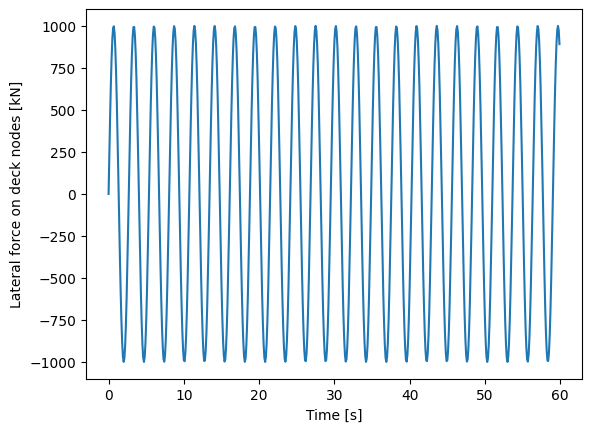

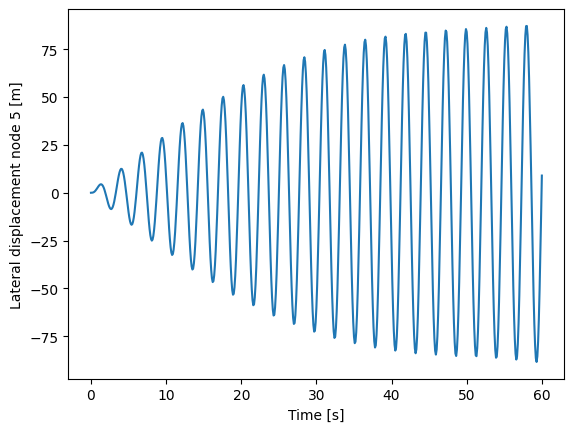

In [28]:
# Plots
node_to_plot = 5
plt.plot(t_force, force_amplitude/1e3)
plt.xlabel('Time [s]'), plt.ylabel('Lateral force on deck nodes [kN]')
plt.figure()
plt.plot(analysis.t, analysis.u[node_to_plot*6 + 1, :])
__,__ = plt.xlabel('Time [s]'), plt.ylabel(f'Lateral displacement node {node_to_plot} [m]')